In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

<h2 id="formulation-of-the-problem">Formulation of the problem</h2>

<p>This problem, taken from McElreath’s book, involves a seal (or a well trained human) tossing a globe, catching it  on the nose, and noting down if the globe came down on  water or land.</p>

<p>The seal tells us that the first 9 samples were:</p>

<p><code class="highlighter-rouge">WLWWWLWLW</code>.</p>

<p>We wish to understand the evolution of belief in the fraction of water on earth as the seal tosses the globe.</p>

<p>Suppose $\theta$ is the true fraction of  water covering the globe. Our data story if that $\theta$ then is the probability of the nose landing on water, with each throw or toss of the globe being independent.</p>

<p>Now we build a  probabilistic model for the problem, which we shall use to guide a process of <strong>Bayesian updating</strong> of the model as data comes in.</p>

<script type="math/tex; mode=display">\cal{L} = p(n,k|\theta) = Binom(n,k, \theta)=\frac{n!}{k! (n-k)! } \, \theta^k \, (1-\theta)^{(n-k)}</script>

<p>Since our seal hasnt really seen any water or land, (strange, I know), it assigns equal probabilities, ie uniform probability to any value of $\theta$.</p>

<p><strong>This is our prior information</strong></p>

<p>For reasons of conjugacy we 
choose as prior the beta distribution, with $Beta(1,1)$ being the uniform prior.</p>

<h2 id="how-to-do-the-bayesian-process">How to do the Bayesian Process</h2>

<p>Bayes theorem and the things we will go through</p>

<p>(1) Grid approximation
(2) Quadratic (Laplace) Approximation
(3) Conjugate Priors
(4) MCMC (later)
(5) Model Checking</p>

<h2 id="grid-approximation">Grid Approximation</h2>

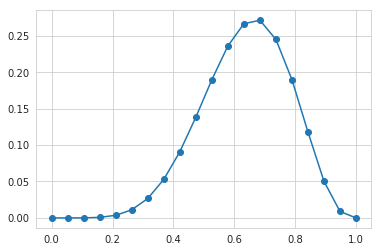

In [2]:
from scipy.stats import binom

prior_pdf = lambda p: 1
like_pdf = lambda p: binom.pmf(k=6, n=9, p=p)
post_pdf = lambda p: like_pdf(p)*prior_pdf(p)
p_grid = np.linspace(0., 1., 20)
plt.plot(p_grid, post_pdf(p_grid),'o-')

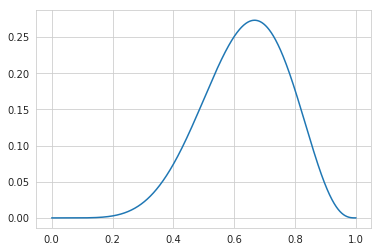

In [3]:
p_grid = np.linspace(0., 1., 1000)
post_vals = post_pdf(p_grid)
post_vals_normed = post_vals/np.sum(post_vals)
grid_post_samples = np.random.choice(p_grid, size=10000, replace=True, p=post_vals_normed)

plt.plot(p_grid, post_vals)

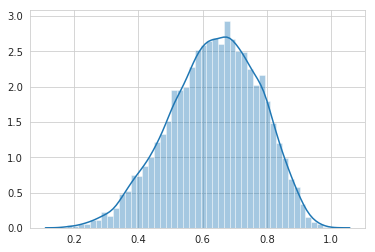

In [4]:
sns.distplot(grid_post_samples)

## Laplace Approximation

In [5]:
p_start = 0.5
from scipy.optimize import minimize
post_pdf_inv = lambda p: -post_pdf(p)
res = minimize(post_pdf_inv, p_start, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: -0.273129
         Iterations: 13
         Function evaluations: 26


In [6]:
res

 final_simplex: (array([[0.66669922],
       [0.66660156]]), array([-0.27312909, -0.27312907]))
           fun: -0.2731290903134583
       message: 'Optimization terminated successfully.'
          nfev: 26
           nit: 13
        status: 0
       success: True
             x: array([0.66669922])

In [7]:
post_MAP = res.x[0]
post_MAP


0.6666992187500004

In [8]:
insertbefore = np.searchsorted(p_grid, post_MAP)
insertbefore

667

In [9]:
postmapval = (post_vals[insertbefore-1] + post_vals[insertbefore])/2.
postmapval

0.27312632244812723

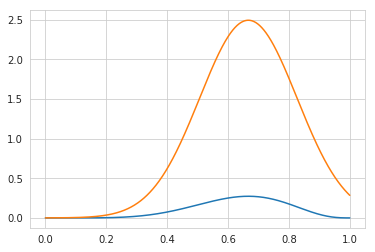

In [10]:
plt.plot(p_grid, post_vals);
plt.plot(p_grid, norm.pdf(p_grid, loc=post_MAP, scale=0.16))

Optimization terminated successfully.
         Current function value: 23.987144
         Iterations: 12
         Function evaluations: 24


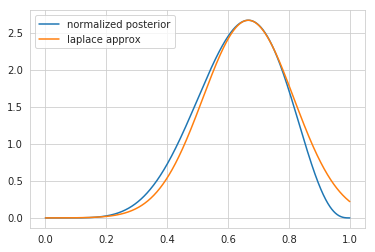

In [12]:
zq = lambda sigma: sigma*postmapval*np.sqrt(2*np.pi)

def fit_loss(sigma):
    vec = (post_vals/zq(sigma)) - norm.pdf(p_grid, loc=post_MAP, scale=sigma)
    return np.dot(vec, vec)

res2 = minimize(fit_loss, 0.2, method = 'Nelder-Mead', options={'disp': True})

post_SIG = res2.x[0]

frozen_laplace = norm(post_MAP, post_SIG)

plt.plot(p_grid, post_pdf(p_grid)/zq(post_SIG), label = "normalized posterior");
plt.plot(p_grid, frozen_laplace.pdf(p_grid), label = "laplace approx")
plt.legend()

Now we can get samples from here:

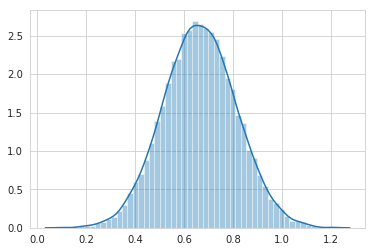

In [13]:
sns.distplot(frozen_laplace.rvs(10000))

<h2 id="conjugate-priors">Conjugate Priors</h2>

<p>The  mean of $Beta(\alpha, \beta)$ is  $\mu = \frac{\alpha}{\alpha+\beta}$ while the variance is</p>
$$V=\mu (1- \mu)/(\alpha + \beta + 1)$$

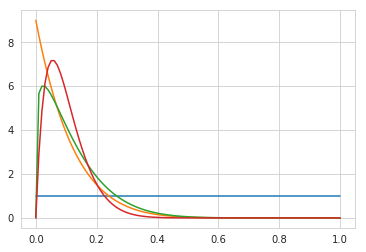

In [14]:
from scipy.stats import beta
x=np.linspace(0., 1., 100)
plt.plot(x, beta.pdf(x, 1, 1));
plt.plot(x, beta.pdf(x, 1, 9));
plt.plot(x, beta.pdf(x, 1.2, 9));
plt.plot(x, beta.pdf(x, 2, 18));


<p>We shall choose $\alpha=1$ and $\beta=1$ to be uniform.</p>

<p><script type="math/tex">p(\theta) = {\rm Beta}(\theta,\alpha, \beta) = \frac{\theta^{\alpha-1} (1-x)^{\beta-1} }{B(\alpha, \beta)}</script>
where $B(\alpha, \beta)$ is independent of $\theta$ and it is the normalization factor.</p>

<p>From Bayes theorem, the posterior for $\theta$ is</p>

<script type="math/tex; mode=display">p(\theta|D) \propto  p(\theta) \, p(n,k|\theta)  =  Binom(n,k, \theta) \,  {\rm Beta}(\theta,\alpha, \beta)</script>

<p>which can be shown to be</p>

<script type="math/tex; mode=display">{\rm Beta}(\theta, \alpha+k, \beta+n-k)</script>

[1 0 1 1 1 0 1 0 1]


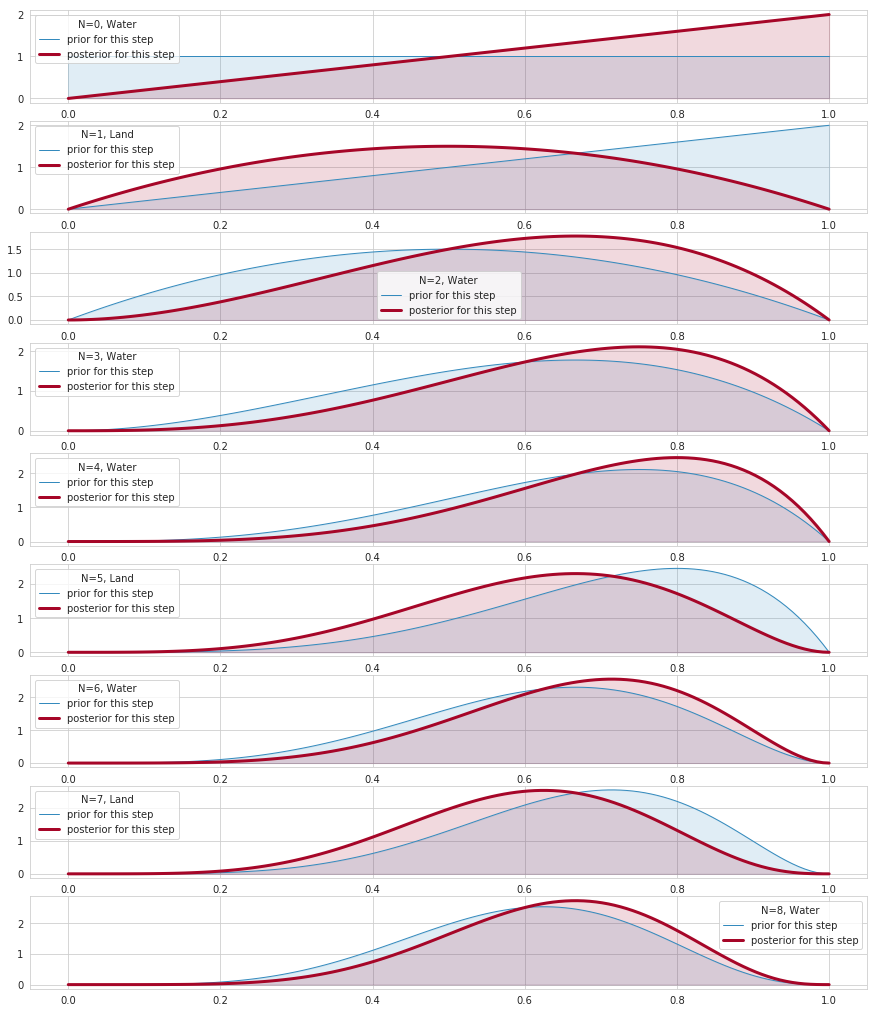

In [15]:
from scipy.stats import beta, binom

plt.figure(figsize=( 15, 18))

prior_params = np.array( [1.,1.] )  # FLAT 

x = np.linspace(0.00, 1, 125)
datastring = "WLWWWLWLW"
data=[]
for c in datastring:
    data.append(1*(c=='W'))
data=np.array(data)
print(data)
choices=['Land','Water']


for i,v in enumerate(data):
    plt.subplot(9,1,i+1)
    prior_pdf = beta.pdf( x, *prior_params)
    if v==1:
        water = [1,0]
    else:
        water = [0,1]
    posterior_params = prior_params + np.array( water )    # posteriors beta parameters
    posterior_pdf = beta.pdf( x, *posterior_params)  # the posterior 
    prior_params = posterior_params
    plt.plot( x,prior_pdf, label = r"prior for this step", lw =1, color ="#348ABD" )
    plt.plot( x, posterior_pdf, label = "posterior for this step", lw= 3, color ="#A60628" )
    plt.fill_between( x, 0, prior_pdf, color ="#348ABD", alpha = 0.15) 
    plt.fill_between( x, 0, posterior_pdf, color ="#A60628", alpha = 0.15) 
    
    plt.legend(title = "N=%d, %s"%(i, choices[v]));
    #plt.ylim( 0, 10)#

<h2 id="interrogating-the-posterior">Interrogating the posterior</h2>

<p>Since we can sample from the posterior now after 9 observations, lets do so!</p>

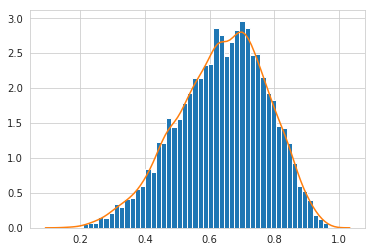

In [17]:
samples = beta.rvs(*posterior_params, size=10000)
plt.hist(samples, bins=50, density=True);
sns.kdeplot(samples);

Sampling to summarize
Now we can calculate all sorts of stuff.

The probability that the amount of water is less than 50%



In [18]:
np.mean(samples < 0.5)

0.1726

The probability by which we get 80% of the samples.

In [19]:
np.percentile(samples, 80)

0.7593627546031911

You might try and find a credible interval. This, unlike the wierd definition of confidence intervals, is exactly what you think it is, the amount of probability mass between certain percentages, like the middle 95%

In [20]:
np.percentile(samples, [2.5, 97.5])

array([0.34268237, 0.87722972])

You can make various point estimates: mean, median

In [21]:
np.mean(samples), np.median(samples), np.percentile(samples, 50) #last 2 are same


(0.6377157778900462, 0.6475546574507738, 0.6475546574507738)

A particularly important and useful point estimate that we just saw is the MAP, or “maximum a-posteriori” estimate, the value of the parameter at which the pdf (num-samples) reach a maximum. It can be obtained from the samples as well.

In [22]:
sampleshisto = np.histogram(samples, bins=50)
maxcountindex = np.argmax(sampleshisto[0])
mapvalue = sampleshisto[1][maxcountindex]
print(maxcountindex, mapvalue)

33 0.6918368645690016


The mean of the posterior samples corresponds to minimizing the squared loss.



Mean 0.6377157778900462


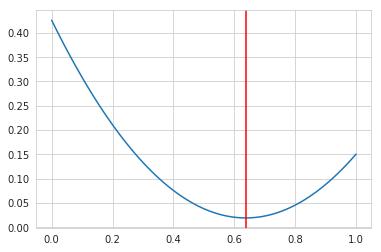

In [23]:
mse = [np.mean((xi-samples)**2) for xi in x]
plt.plot(x, mse);
plt.axvline(np.mean(samples), 0, 1, color="r")
print("Mean",np.mean(samples));

<h2 id="sampling-to-simulate-prediction-the-posterior-predictive">Sampling to simulate prediction: the posterior predictive</h2>

<p>Why would you want to simulate prediction?</p>

<ol>
  <li>Model Checking</li>
  <li>Software Validation</li>
  <li>Research Design</li>
  <li>Forecasting</li>
</ol>

<p>Its easy to sample from any one probability to get the sampling distribution at a particular $\theta$</p>

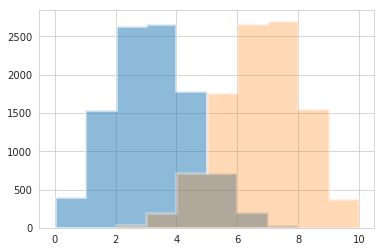

In [24]:
point3samps = np.random.binomial( len(data), 0.3, size=10000);
point7samps = np.random.binomial( len(data), 0.7, size=10000);
plt.hist(point3samps, lw=3, alpha=0.5, histtype="stepfilled", bins=np.arange(11));
plt.hist(point7samps, lw=3, alpha=0.3,histtype="stepfilled", bins=np.arange(11));

<p><img src="/wiki/globemodellab_files/globemodellab_49_0.png" alt="png" /></p>

<p>The posterior predictive:</p>

<script type="math/tex; mode=display">p(y^{*} \vert D) = \int d\theta p(y^{*} \vert \theta) p(\theta \vert D)</script>

<p>seems to be a complex integral.  But if you parse it, its not so complex. This diagram from McElreath helps:</p>

<p><img src="images/postpred.png" alt="" /></p>

<h3 id="plug-in-approximation">Plug-in Approximation</h3>

<p>Also, often, people will use the <strong>plug-in approximation</strong> by putting the posterior mean or MAP value</p>

<script type="math/tex; mode=display">p(\theta \vert D) = \delta(\theta - \theta_{MAP})</script>

<p>and then simply  drawing the posterior predictive  from :</p>

<script type="math/tex; mode=display">p(y^{*} \vert D) = p(y^{*} \vert \theta_{MAP})</script>

<p>(the same thing could be done for $\theta_{mean}$).</p>


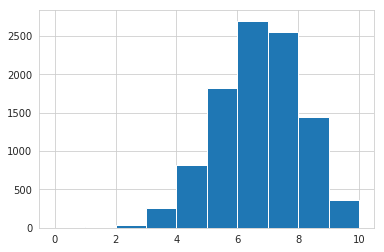

In [25]:
pluginpreds = np.random.binomial( len(data), mapvalue, size = len(samples))
plt.hist(pluginpreds, bins=np.arange(11));


<p>This approximation is just sampling from the likelihood(sampling distribution), at a posterior-obtained value of $\theta$.  It might be useful if the posterior is an expensive MCMC and the MAP is easier to find by optimization, and can be used in conjunction with quadratic (gaussian) approximations to the posterior, as we will see in variational inference. But for now we have all the samples, and it would be inane not to use them…</p>

<h3 id="the-posterior-predictive-from-sampling">The posterior predictive from sampling</h3>

<p>But really from the perspective of sampling, all we have to do is to first draw the thetas from the posterior, then draw y’s from the likelihood, and histogram the likelihood. This is the same logic as marginal posteriors, with the addition of the fact that we must draw  y from the likelihood once we drew $\theta$. You might think that we have to draw multiple $y$s at a theta, but this is already taken care of for us because of the nature of sampling. We already have multiple $\theta$s in a bin.</p>


In [26]:
postpred = np.random.binomial( len(data), samples);
samples.shape, postpred.shape


((10000,), (10000,))

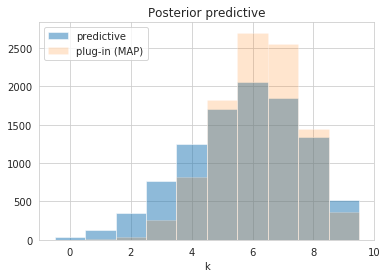

In [27]:
plt.hist(postpred, bins=np.arange(11), alpha=0.5, align="left", label="predictive")
plt.hist(pluginpreds, bins=np.arange(11), alpha=0.2, align="left", label="plug-in (MAP)")
plt.title('Posterior predictive')
plt.xlabel('k')
plt.legend()

<h3 id="replicative-predictives">Replicative predictives</h3>

<p>There is a different kind of predictive sampling that us useful (and what you might have thought was predictive sampling). This is replicative sampling. It can be used with both priors and posteriors; the former for model callibration and the latter for model checking. We shall see both of these soon.</p>

<p>The idea here is to generate an entire dataset from one of the parameter samples in the posterior. So you are not generating 10000 ys for 10000 thetas, but rather 10000 y’s per theta. (you can play the same game with the prior). This kind of inverts the diagram we saw earlier to produce the posterior predictive.</p>

<p>Our usual sample vs replication 2D setup can come useful here. Consider generating 1000 y’s per replication for each theta.</p>

In [28]:
reppostpred =np.empty((1000, 10000))
for i in range(1000):
    reppostpred[i,:] = np.random.binomial( len(data), samples);
reppostpred.shape


(1000, 10000)

In [29]:
per_theta_avgs = np.mean(reppostpred, axis=0)
per_theta_avgs.shape

(10000,)

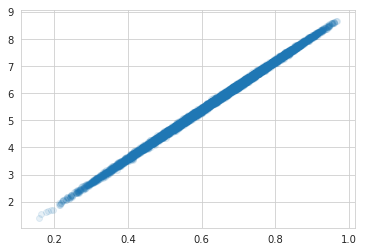

In [30]:
plt.scatter(samples, per_theta_avgs, alpha=0.1);


In particular, you will find that the number of switches is not consistent with what you see in our data. This might lead you to question our model…always a good thing..but note that we have very little data as yet to go on

In [31]:
data

array([1, 0, 1, 1, 1, 0, 1, 0, 1])

In [32]:
data[:-1] != data[1:]


array([ True,  True, False, False,  True,  True,  True,  True])

In [33]:
np.sum(data[:-1] != data[1:])


6

<h2 id="exercise">Exercise</h2>

<p>You can interrogate the posterior-predictive, or <strong>simulated</strong> samples in other ways, asking about the longest run of water tosses, or the number of times the water/land switched. This is left as an exercise.</p>